## DATA

In [1]:
import os
from pathlib import Path

# Fake Data
import wikipedia
import urllib.request

# plotting
import matplotlib.pyplot as plt
from PIL import Image

# VectorDB
import chromadb

# Used for Custom Embedding Functions
from chromadb import Documents, EmbeddingFunction, Embeddings
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from transformers import AutoModel, AutoTokenizer

# Data Loader Functions
from chromadb.utils.data_loaders import ImageLoader
from llama_index.core import SimpleDirectoryReader

# Vector Store
from llama_index.vector_stores.chroma import ChromaVectorStore
from llama_index.core import VectorStoreIndex, StorageContext

# Response
from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.schema import ImageNode


def generate_wiki_data():
    image_path = Path("data_wiki")
    image_uuid = 0
    image_metadata_dict = {}
    MAX_IMAGES_PER_WIKI = 30

    wiki_titles = [
        "batman",
        "Vincent van Gogh",
        "San Francisco",
        "iPhone",
        "Tesla Model S",
    ]

    # create folder for images only
    if not image_path.exists():
        Path.mkdir(image_path)

    for title in wiki_titles:
        images_per_wiki = 0
        print(title)
        try:
            page_py = wikipedia.page(title)
            list_img_urls = page_py.images
            for url in list_img_urls:
                if url.endswith(".jpg") or url.endswith(".png"):
                    image_uuid += 1
                    image_file_name = title + "_" + url.split("/")[-1]

                    # img_path could be s3 path pointing to the raw image file in the future
                    image_metadata_dict[image_uuid] = {
                        "filename": image_file_name,
                        "img_path": "./" + str(image_path / f"{image_uuid}.jpg"),
                    }
                    urllib.request.urlretrieve(url, image_path / f"{image_uuid}.jpg")
                    images_per_wiki += 1
                    # Limit the number of images downloaded per wiki page to 15
                    if images_per_wiki > MAX_IMAGES_PER_WIKI:
                        break
        except:
            print(str(Exception("No images found for Wikipedia page: ")) + title)
            continue


class TextEmbedding(EmbeddingFunction):
    def __call__(self, input: Documents) -> Embeddings:
        model_name = "sentence-transformers/paraphrase-MiniLM-L6-v2"
        tokenizer_name = model_name  # usually the same as model_name
        model = AutoModel.from_pretrained(model_name)
        tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
        embeddings = HuggingFaceEmbedding(
            model_name=model_name,
            tokenizer_name=tokenizer_name,
            model=model,
            tokenizer=tokenizer,
            max_length=None,
        )
        return embeddings


class ImageEmbedding(EmbeddingFunction):
    def __call__(self, input: Documents) -> Embeddings:
        model_name = "openai/clip-vit-base-patch16"
        tokenizer_name = model_name  # usually the same as model_name
        model = AutoModel.from_pretrained(model_name)
        tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
        embeddings = HuggingFaceEmbedding(
            model_name=model_name,
            tokenizer_name=tokenizer_name,
            model=model,
            tokenizer=tokenizer,
            max_length=None,
        )
        return embeddings


def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(2, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break
    plt.show()


generate_wiki_data()


c:\Users\aakas\miniconda3\envs\honeybee\Lib\site-packages\onnxruntime\capi\onnxruntime_validation.py:26: UserWarning: Unsupported Windows version (11). ONNX Runtime supports Windows 10 and above, only.
  warnings.warn(


batman
Vincent van Gogh
San Francisco
No images found for Wikipedia page: San Francisco
iPhone
No images found for Wikipedia page: iPhone
Tesla Model S
No images found for Wikipedia page: Tesla Model S


## Setup RAG

In [2]:
image_loader = ImageLoader()
text_embedding_function = TextEmbedding()
image_embedding_function = ImageEmbedding()

chroma_client = chromadb.PersistentClient(path="DB")

text_collection = chroma_client.get_or_create_collection(
    name="text_collection",
    embedding_function=text_embedding_function,
)
image_collection = chroma_client.get_or_create_collection(
    name="image_collection",
    embedding_function=image_embedding_function,
    data_loader=image_loader,
)

vector_store = ChromaVectorStore(chroma_collection=text_collection)
image_store = ChromaVectorStore(chroma_collection=image_collection)

storage_context = StorageContext.from_defaults(
    vector_store=vector_store,
    image_store=image_store,
)

documents = SimpleDirectoryReader("./data_wiki/").load_data()
index = VectorStoreIndex.from_documents(
    documents,
    storage_context=storage_context,
    show_progress=True,
    embed_model="local",
)

c:\Users\aakas\miniconda3\envs\honeybee\Lib\site-packages\PIL\Image.py:3186: DecompressionBombWarning: Image size (101972528 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Parsing nodes:   0%|          | 0/54 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/54 [00:00<?, ?it/s]

## Use RAG

c:\Users\aakas\miniconda3\envs\honeybee\Lib\site-packages\PIL\Image.py:3186: DecompressionBombWarning: Image size (101972528 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


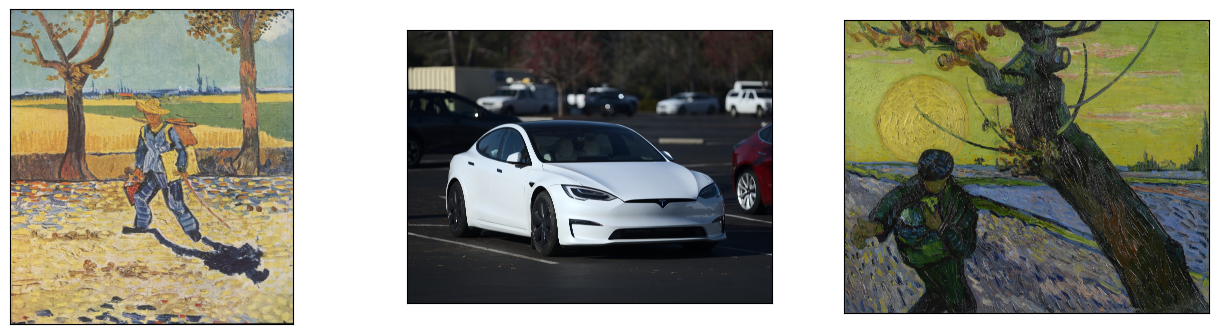

In [4]:
test_query = "what are Vincent van Gogh's famous paintings"
# generate  retrieval results
retriever = index.as_retriever(similarity_top_k=3, image_similarity_top_k=5)
retrieval_results = retriever.retrieve(test_query)

retrieved_image = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_image.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=200)

plot_images(retrieved_image)

## Chroma

In [5]:
image_collection.peek()

{'ids': [],
 'embeddings': [],
 'metadatas': [],
 'documents': [],
 'uris': None,
 'data': None}

In [6]:
text_collection.peek()

{'ids': ['0424e202-d81e-4eb2-af23-f291c9b15f46',
  '07a93982-6554-4fda-a4f1-65feb40275cf',
  '0a16bdbf-3308-4242-bec5-9ac2a4ae4915',
  '0bebaf8a-0d03-492b-8451-78fb4a75a1a2',
  '0c40a309-bdea-4e82-a184-244e6c0f56d5',
  '0eadc916-5b6a-43e9-a915-452cd73a0b89',
  '15a755ea-fe88-4c29-a815-42be84e3a64e',
  '16ce74d3-5899-4004-a1ea-14f2b84ef365',
  '202364cd-a226-4e72-bcc0-c455d239ec04',
  '2d9a3583-894c-4ca1-afd9-f54aad023260'],
 'embeddings': [[-0.062215350568294525,
   -0.06300049275159836,
   0.0008505037403665483,
   -0.028584811836481094,
   0.06967555731534958,
   0.00459924153983593,
   -0.0416451022028923,
   0.0030788599979132414,
   -0.03692847862839699,
   -0.012626871466636658,
   0.03966899961233139,
   -0.06492999941110611,
   0.019480062648653984,
   0.001385491224937141,
   0.03256789967417717,
   0.028081553056836128,
   0.04985528811812401,
   0.012742267921566963,
   -0.03548275679349899,
   0.035320986062288284,
   0.04983102157711983,
   -0.05909007787704468,
   0.03563

In [10]:
text_collection.get("0424e202-d81e-4eb2-af23-f291c9b15f46")

{'ids': ['0424e202-d81e-4eb2-af23-f291c9b15f46'],
 'embeddings': None,
 'metadatas': [{'_node_content': '{"id_": "0424e202-d81e-4eb2-af23-f291c9b15f46", "embedding": null, "metadata": {"file_path": "data_wiki\\\\47.jpg", "file_name": "47.jpg", "file_type": "image/jpeg", "file_size": 6373937, "creation_date": "2024-02-21", "last_modified_date": "2024-02-21", "last_accessed_date": "2024-02-21"}, "excluded_embed_metadata_keys": ["file_name", "file_type", "file_size", "creation_date", "last_modified_date", "last_accessed_date"], "excluded_llm_metadata_keys": ["file_name", "file_type", "file_size", "creation_date", "last_modified_date", "last_accessed_date"], "relationships": {"1": {"node_id": "b8b167cc-986b-405e-8a83-3747bcb5e0e4", "node_type": "4", "metadata": {"file_path": "data_wiki\\\\47.jpg", "file_name": "47.jpg", "file_type": "image/jpeg", "file_size": 6373937, "creation_date": "2024-02-21", "last_modified_date": "2024-02-21", "last_accessed_date": "2024-02-21"}, "hash": "9e7af28652